## Two Algorithms:

I have two versions of this algorithm 

1. Using laplace noise for all privacy noise. 
2. Using the google privacy accountant to get parameters for gaussian and discrete laplace noise. 

It would be interesting to see if using the gaussian and dlaplace noise instead makes any significant difference 

### Parameters 

- max_depth: How deep the LSH tree should be constructed
- branching_threshold: Minimum number of nodes required to branch
- include_threshold: Minimum number of nodes required to include in final coreset

Algorithm 1: The split of privacy over constructing tree and private averages (default 0.8/0.2)


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from bucket import create_bucket_synopsis, bucket_using_privacy_accountant, Params
from evaluation_utils import kmeans_loss
from lloyd import lloyd_with_weights

master_rng = np.random.default_rng(42)

def lsh_experiment(algo: int, data: np.ndarray, p: Params, n_trials: int = 20):
    s = master_rng.integers(low=0, high=100000)
    total_loss = 0
    for x in range(n_trials):
        if algo == 1:
            private_points, private_weights = create_bucket_synopsis(data, p, s+x)
        else:
            private_points, private_weights = bucket_using_privacy_accountant(data, p, s+x)
        if private_points.shape[0] <= p.k: # if number of points is less than or equal to desired number of centers
            centers = private_points
        else:
            centers = lloyd_with_weights(k=p.k, X=private_points, weights=private_weights, n_iter=5, rs=s+x)
        loss = kmeans_loss(centers, data)
        total_loss += loss
    return total_loss / n_trials


level 0 [281]
level 1 [181, 81]
level 2 [-19, 181]
level 3 [20, 142]
Algorithm 1 loss: 0.14160255655115378
Algorithm 2 loss: 0.13899726693031333


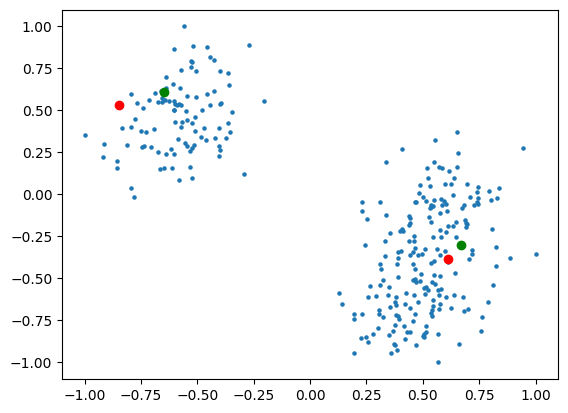

In [2]:
small = np.load("datasets/synthetic-gaussian.npy")
p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3)
points1, weights1 = create_bucket_synopsis(small, p, seed=454)
points2, weights2 = bucket_using_privacy_accountant(small, p, seed=454)

# the algorithm only returns 2 points. since we wanted k=3, these points will just become the centers. 
plt.scatter(small[:,0], small[:,1], s=5)
plt.scatter(points1[:,0], points1[:,1], c="red")
plt.scatter(points2[:,0], points2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(points1, small)}")
print(f"Algorithm 2 loss: {kmeans_loss(points2, small)}")

In [3]:
# vary max depth for default branching threshold, include threshold. Note that max depth has to be chosen before computing any noise so it cannot depend on the other parameters

values = [5, 10, 15, 20, 25, 30, 35, 40]

for d in values:
    p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=d)
    avg_loss = lsh_experiment(1, small, p)
    print(f"max depth = {d} avg loss = {avg_loss}")

max depth = 5 avg loss = 0.3456359748810044
max depth = 10 avg loss = 0.27521148941703893
max depth = 15 avg loss = 0.13241412438739433
max depth = 20 avg loss = 0.2609125630900056
max depth = 25 avg loss = 0.27900387854950337
max depth = 30 avg loss = 0.23544799287818444
max depth = 35 avg loss = 0.27269989498467206
max depth = 40 avg loss = 0.17137361446070992
